In [4]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [5]:
path = os.listdir('SDSS_20k/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [6]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

872
15249
32951
37233
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


In [7]:
np.min(Image_RGB)

-0.1562042649972083

In [8]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (140976, 64, 64, 5)
train_label.shape: (140976, 3)


In [9]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [10]:
autoencoder.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(train_data[12000:20000],train_data[12000:20000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 8000 samples
Epoch 1/100
12000/12000 [==============================] - 24s - loss: 0.5341 - val_loss: 0.3393
Epoch 2/100
12000/12000 [==============================] - 17s - loss: 0.1781 - val_loss: 0.2928
Epoch 3/100
12000/12000 [==============================] - 18s - loss: 0.1487 - val_loss: 0.2332
Epoch 4/100
12000/12000 [==============================] - 18s - loss: 0.1322 - val_loss: 0.1470
Epoch 5/100
12000/12000 [==============================] - 17s - loss: 0.1229 - val_loss: 0.2145
Epoch 6/100
12000/12000 [==============================] - 17s - loss: 0.1173 - val_loss: 0.1446
Epoch 7/100
12000/12000 [==============================] - 17s - loss: 0.1101 - val_loss: 0.1114
Epoch 8/100
12000/12000 [==============================] - 17s - loss: 0.1072 - val_loss: 0.1177
Epoch 9/100
12000/12000 [==============================] - 17s - loss: 0.1034 - val_loss: 0.1300
Epoch 10/100
12000/12000 [==============================] - 18s - loss: 0.1011

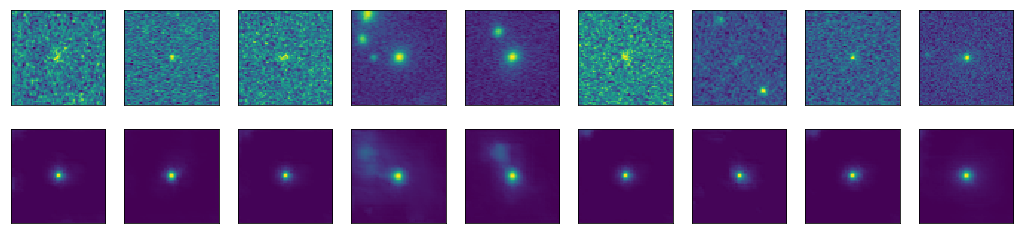

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [12]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:20000],batch_size=100)
encoded_variables.shape

(20000, 30)

In [13]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=3, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [14]:
classifier.fit(encoded_variables, label[:20000], batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 0s - loss: 0.8851 - acc: 0.6572 - val_loss: 0.7188 - val_acc: 0.7632
Epoch 2/40
16000/16000 [==============================] - 0s - loss: 0.5689 - acc: 0.8184 - val_loss: 0.4822 - val_acc: 0.8285
Epoch 3/40
16000/16000 [==============================] - 0s - loss: 0.4420 - acc: 0.8438 - val_loss: 0.4269 - val_acc: 0.8470
Epoch 4/40
16000/16000 [==============================] - 0s - loss: 0.4074 - acc: 0.8544 - val_loss: 0.4051 - val_acc: 0.8510
Epoch 5/40
16000/16000 [==============================] - 0s - loss: 0.3900 - acc: 0.8589 - val_loss: 0.3937 - val_acc: 0.8510
Epoch 6/40
16000/16000 [==============================] - 0s - loss: 0.3796 - acc: 0.8608 - val_loss: 0.3847 - val_acc: 0.8542
Epoch 7/40
16000/16000 [==============================] - 1s - loss: 0.3720 - acc: 0.8633 - val_loss: 0.3784 - val_acc: 0.8540
Epoch 8/40
16000/16000 [==============================] - 0s -

In [15]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

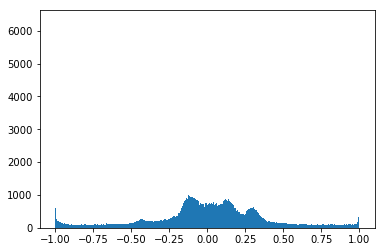

In [16]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [17]:
net_3_input= Input(shape=(30,))
encoded = Dense(2, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [18]:
autoencoder.fit(Zero_one_normalized_encoded_variables[:12000], Zero_one_normalized_encoded_variables[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(Zero_one_normalized_encoded_variables[12000:14000],Zero_one_normalized_encoded_variables[12000:14000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2000 samples
Epoch 1/100
12000/12000 [==============================] - 0s - loss: 0.1680 - val_loss: 0.1353
Epoch 2/100
12000/12000 [==============================] - 0s - loss: 0.1247 - val_loss: 0.1093
Epoch 3/100
12000/12000 [==============================] - 0s - loss: 0.1058 - val_loss: 0.0955
Epoch 4/100
12000/12000 [==============================] - 0s - loss: 0.0944 - val_loss: 0.0866
Epoch 5/100
12000/12000 [==============================] - 0s - loss: 0.0873 - val_loss: 0.0813
Epoch 6/100
12000/12000 [==============================] - 0s - loss: 0.0829 - val_loss: 0.0781
Epoch 7/100
12000/12000 [==============================] - 0s - loss: 0.0803 - val_loss: 0.0763
Epoch 8/100
12000/12000 [==============================] - 0s - loss: 0.0788 - val_loss: 0.0751
Epoch 9/100
12000/12000 [==============================] - 0s - loss: 0.0777 - val_loss: 0.0743
Epoch 10/100
12000/12000 [==============================] - 0s - loss: 0.0770 - val_los

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


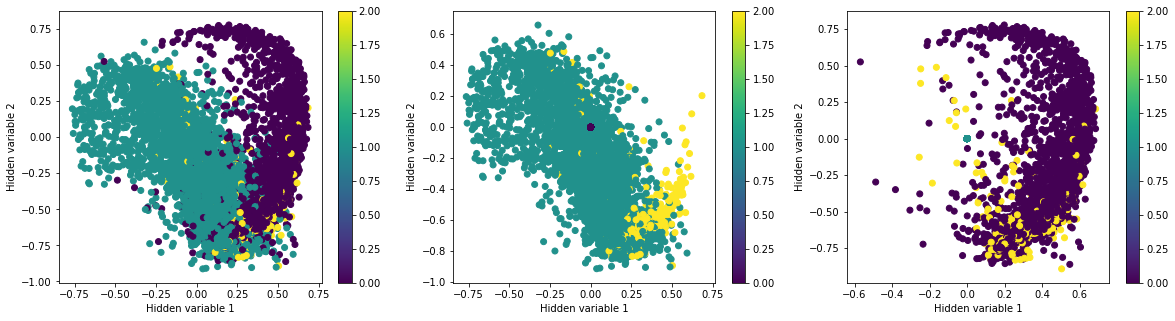

In [19]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [20]:
n_points = np.shape(x_vis)[0]
n_neighbors = 30
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

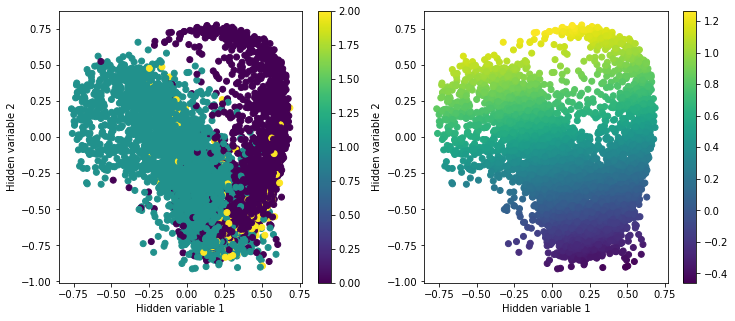

In [21]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred.reshape(-1,)[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

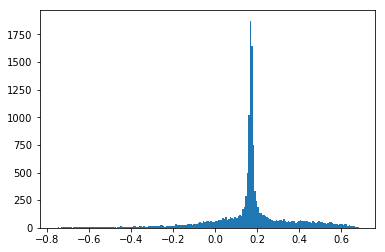

In [22]:
plt.hist(x_vis[:,0],200)
plt.show()

In [23]:
net_3_input= Input(shape=(30,))
encoded = Dense(3, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [24]:
autoencoder.fit(Zero_one_normalized_encoded_variables[:12000], Zero_one_normalized_encoded_variables[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(Zero_one_normalized_encoded_variables[12000:14000],Zero_one_normalized_encoded_variables[12000:14000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2000 samples
Epoch 1/100
12000/12000 [==============================] - 0s - loss: 0.1494 - val_loss: 0.1206
Epoch 2/100
12000/12000 [==============================] - 0s - loss: 0.1149 - val_loss: 0.1011
Epoch 3/100
12000/12000 [==============================] - 0s - loss: 0.0998 - val_loss: 0.0903
Epoch 4/100
12000/12000 [==============================] - 0s - loss: 0.0905 - val_loss: 0.0832
Epoch 5/100
12000/12000 [==============================] - 0s - loss: 0.0834 - val_loss: 0.0773
Epoch 6/100
12000/12000 [==============================] - 0s - loss: 0.0780 - val_loss: 0.0730
Epoch 7/100
12000/12000 [==============================] - 0s - loss: 0.0744 - val_loss: 0.0704
Epoch 8/100
12000/12000 [==============================] - 0s - loss: 0.0723 - val_loss: 0.0688
Epoch 9/100
12000/12000 [==============================] - 0s - loss: 0.0708 - val_loss: 0.0676
Epoch 10/100
12000/12000 [==============================] - 0s - loss: 0.0698 - val_los

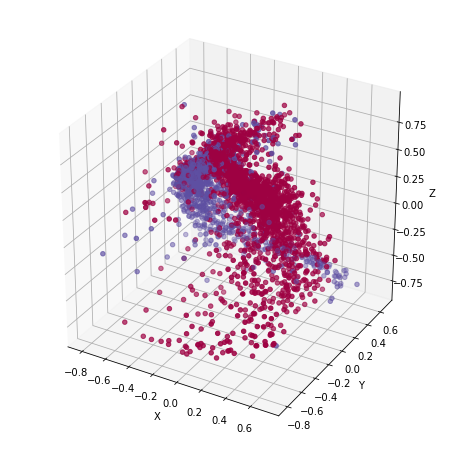

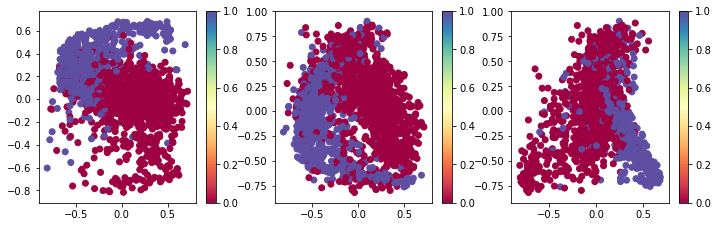

In [25]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
    
vis = Model(net_3_input, encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

In [28]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

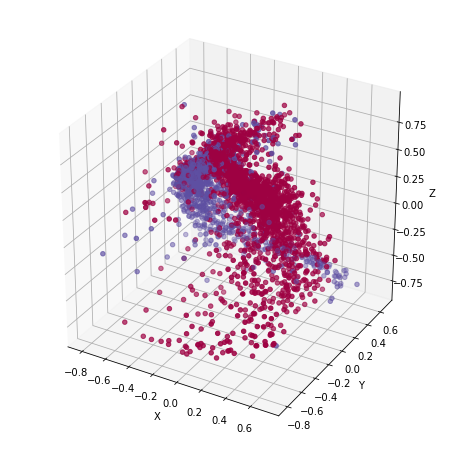

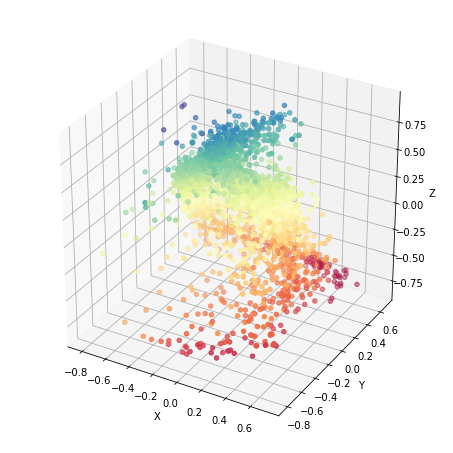

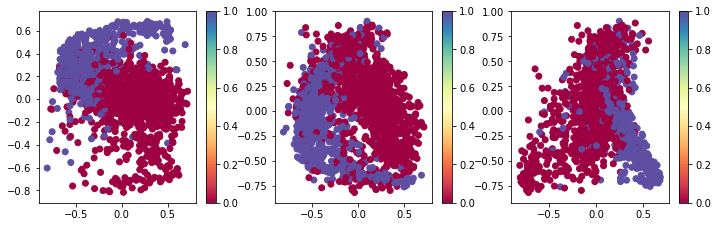

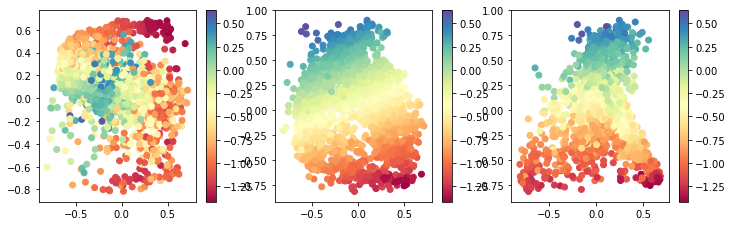

In [29]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()